In [107]:
import pandas as pd

file_path = 'Project Data_2025.csv' # Replace with your actual file path
df = pd.read_csv(file_path, parse_dates=['ActualArrival', 'FirstBagDropTime', 'LastBagDropTime'])
df['DeliveryDurationMins'] = (df['LastBagDropTime'] - df['ActualArrival']).dt.total_seconds() / 60
df['Arrival_To_First'] = (df['FirstBagDropTime'] - df['ActualArrival']).dt.total_seconds() / 60
df['First_To_last'] = (df['LastBagDropTime'] - df['FirstBagDropTime']).dt.total_seconds() / 60

df.shape

/var/folders/f9/h1fzr8_920x1wh3dtpzy4cmh0000gn/T/ipykernel_92441/827869049.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, parse_dates=['ActualArrival', 'FirstBagDropTime', 'LastBagDropTime'])
/var/folders/f9/h1fzr8_920x1wh3dtpzy4cmh0000gn/T/ipykernel_92441/827869049.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, parse_dates=['ActualArrival', 'FirstBagDropTime', 'LastBagDropTime'])
/var/folders/f9/h1fzr8_920x1wh3dtpzy4cmh0000gn/T/ipykernel_92441/827869049.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df 

(99174, 10)

In [108]:
df.head()

,ActualArrival,FlightNumber,Origin,Destination,ExpectedBagsCount,FirstBagDropTime,LastBagDropTime,DeliveryDurationMins,Arrival_To_First,First_To_last
0,2021-07-22 08:20:00,8390,EVF,YZU,6,2021-07-22 08:29:00,2021-07-22 08:29:00,9.0,9.0,0.0
1,2021-07-22 08:20:00,6898,CYT,YZU,24,2021-07-22 08:30:00,2021-07-22 08:31:00,11.0,10.0,1.0
2,2021-07-22 08:20:00,3095,YZU,EVF,27,2021-07-22 08:26:00,2021-07-22 08:29:00,9.0,6.0,3.0
3,2021-07-22 08:31:00,4821,CYT,YUX,17,2021-07-22 08:41:00,2021-07-22 08:45:00,14.0,10.0,4.0
4,2021-07-22 08:33:00,2512,EYT,YZU,32,2021-07-22 08:40:00,2021-07-22 08:42:00,9.0,7.0,2.0


In [173]:
def audit_baggage_data(df):
    audit_results = {}
    bad_rows = {}

    # Ensure datetime columns are parsed correctly
    df['FirstBagDropTime'] = pd.to_datetime(df['FirstBagDropTime'], errors='coerce')
    df['LastBagDropTime'] = pd.to_datetime(df['LastBagDropTime'], errors='coerce')
    df['ActualArrival'] = pd.to_datetime(df['ActualArrival'], errors='coerce')

    # 1. LastBagDropTime >= FirstBagDropTime
    check1 = df[df['LastBagDropTime'] < df['FirstBagDropTime']]
    audit_results['Invalid Bag Drop Order'] = len(check1)
    bad_rows['Invalid Bag Drop Order'] = check1

    # 2. FirstBagDropTime >= ActualArrival
    check2 = df[df['FirstBagDropTime'] < df['ActualArrival']]
    audit_results['Bags Delivered Before Arrival'] = len(check2)
    bad_rows['Bags Delivered Before Arrival'] = check2

    # 3. ExpectedBagsCount not negative
    check4 = df[df['ExpectedBagsCount'] < 0]
    audit_results['Negative Expected Bag Count'] = len(check4)
    bad_rows['Negative Expected Bag Count'] = check4

    # 4. Missing values anywhere
    check5 = df[df.isnull().any(axis=1)]
    audit_results['Rows with Missing Fields'] = len(check5)
    bad_rows['Missing Critical Fields'] = check5

    # 5. Exact duplicate rows
    check6 = df[df.duplicated(keep=False)]
    audit_results['Exact Duplicate Rows'] = len(check6)
    bad_rows['Exact Duplicate Rows'] = check6

    # 6. Partial duplicates: Same FlightNumber + ActualArrival, but NOT exact duplicates
    check7_all = df[df.duplicated(subset=['FlightNumber', 'ActualArrival'], keep=False)] 
    # Exclude rows that are already counted as exact duplicates
    check7 = check7_all[~check7_all.index.isin(check6.index)]
    # Store result
    audit_results['Duplicate Flight Entries'] = len(check7)
    bad_rows['Duplicate Flight Entries'] = check7

    # 7. Origin == Destination
    check8 = df[df['Origin'] == df['Destination']]
    audit_results['Origin Equals Destination'] = len(check8)
    bad_rows['Origin Equals Destination'] = check8

    # 8. 0 Expected Bags but bag drop times present
    check9 = df[(df['ExpectedBagsCount'] == 0) & (df['DeliveryDurationMins'] > 0)]
    audit_results['Bag Drop Times with 0 Expected Bags'] = len(check9)
    bad_rows['Bag Drop Times with 0 Expected Bags'] = check9

    # 9. Substantial ExpectedBagsCount but DeliveryDurationMins == 0
    check10 = df[(df['ExpectedBagsCount'] > 0) & (df['DeliveryDurationMins'] == 0)]
    audit_results['Zero Delivery Duration w/ Bags'] = len(check10)
    bad_rows['Zero Delivery Duration w/ Bags'] = check10

    # Final audit summary
    audit_df = pd.DataFrame.from_dict(audit_results, orient='index', columns=['Issue Count'])
    audit_df.index.name = 'Check'

    return audit_df, bad_rows

In [175]:
audit_df, bad_rows = audit_baggage_data(df)

print("=== AUDIT SUMMARY ===")
print(audit_df)

=== AUDIT SUMMARY ===
                                     Issue Count
Check                                           
Invalid Bag Drop Order                         0
Bags Delivered Before Arrival                  0
Negative Expected Bag Count                    0
Rows with Missing Fields                       0
Exact Duplicate Rows                       14266
Duplicate Flight Entries                      20
Origin Equals Destination                     35
Bag Drop Times with 0 Expected Bags           81
Zero Delivery Duration w/ Bags               117


In [262]:
total_problem_rows = len(set().union(*[df_.index for df_ in bad_rows.values()]))

In [264]:
total_problem_rows

14451

In [177]:
bad_rows['Duplicate Flight Entries']

,ActualArrival,FlightNumber,Origin,Destination,ExpectedBagsCount,FirstBagDropTime,LastBagDropTime,DeliveryDurationMins,Arrival_To_First,First_To_last
5389,2021-08-06 11:38:00,338,WYV,FTU,58,2021-08-06 11:53:00,2021-08-06 11:55:00,17.0,15.0,2.0
5390,2021-08-06 11:38:00,338,YXY,FTU,42,2021-08-06 11:52:00,2021-08-06 11:54:00,16.0,14.0,2.0
38696,2021-11-07 22:11:00,42,FTU,AAW,65,2021-11-07 22:24:00,2021-11-07 22:26:00,15.0,13.0,2.0
38697,2021-11-07 22:11:00,42,CBZ,WWT,110,2021-11-07 22:20:00,2021-11-07 22:28:00,17.0,9.0,8.0
43263,2021-11-20 08:48:00,567,XFA,FTU,67,2021-11-20 09:06:00,2021-11-20 09:10:00,22.0,18.0,4.0
43264,2021-11-20 08:48:00,567,EXT,FTU,54,2021-11-20 09:08:00,2021-11-20 09:12:00,24.0,20.0,4.0
52727,2021-12-18 21:27:00,34,WWT,XXB,77,2021-12-18 21:31:00,2021-12-18 21:40:00,13.0,4.0,9.0
69025,2022-02-06 13:52:00,592,XCB,EYT,33,2022-02-06 14:05:00,2022-02-06 14:07:00,15.0,13.0,2.0
69026,2022-02-06 13:52:00,592,BEY,FTU,10,2022-02-06 14:03:00,2022-02-06 14:03:00,11.0,11.0,0.0
77028,2022-02-16 13:13:00,7304,WET,WWA,31,2022-02-16 13:23:00,2022-02-16 13:25:00,12.0,10.0,2.0


In [179]:
bad_rows['Origin Equals Destination'].head()

,ActualArrival,FlightNumber,Origin,Destination,ExpectedBagsCount,FirstBagDropTime,LastBagDropTime,DeliveryDurationMins,Arrival_To_First,First_To_last
12385,2021-08-29 14:12:00,2583,XCB,XCB,23,2021-08-29 14:17:00,2021-08-29 14:18:00,6.0,5.0,1.0
49438,2021-12-09 13:27:00,92,CAX,CAX,91,2021-12-09 13:30:00,2021-12-09 13:37:00,10.0,3.0,7.0
49439,2021-12-09 13:27:00,92,CAX,CAX,91,2021-12-09 13:30:00,2021-12-09 13:37:00,10.0,3.0,7.0
49440,2021-12-09 13:27:00,92,CAX,CAX,91,2021-12-09 13:30:00,2021-12-09 13:37:00,10.0,3.0,7.0
49441,2021-12-09 13:27:00,92,CAX,CAX,91,2021-12-09 13:30:00,2021-12-09 13:37:00,10.0,3.0,7.0


In [181]:
bad_rows['Bag Drop Times with 0 Expected Bags'].head()

,ActualArrival,FlightNumber,Origin,Destination,ExpectedBagsCount,FirstBagDropTime,LastBagDropTime,DeliveryDurationMins,Arrival_To_First,First_To_last
58,2021-07-22 10:31:00,1985,WWC,FTU,0,2021-07-22 10:40:00,2021-07-22 10:40:00,9.0,9.0,0.0
1063,2021-07-25 06:07:00,5814,VED,FTU,0,2021-07-25 06:27:00,2021-07-25 06:27:00,20.0,20.0,0.0
1112,2021-07-25 12:25:00,8846,DFX,FTU,0,2021-07-25 12:37:00,2021-07-25 12:38:00,13.0,12.0,1.0
1924,2021-07-27 10:31:00,4201,DFX,FTU,0,2021-07-27 10:47:00,2021-07-27 10:47:00,16.0,16.0,0.0
2889,2021-07-30 06:21:00,90,WWA,FTU,0,2021-07-30 06:29:00,2021-07-30 06:29:00,8.0,8.0,0.0


In [183]:
# Find partial duplicates (same flight and arrival, but different full rows)
flight_dups = df[df.duplicated(subset=['FlightNumber', 'ActualArrival'], keep=False)]
not_exact_dups = flight_dups[~flight_dups.duplicated(keep=False)]

print(f"Partial duplicates (same flight/time, diff content): {len(not_exact_dups)}")
not_exact_dups.head()

Partial duplicates (same flight/time, diff content): 20


,ActualArrival,FlightNumber,Origin,Destination,ExpectedBagsCount,FirstBagDropTime,LastBagDropTime,DeliveryDurationMins,Arrival_To_First,First_To_last
5389,2021-08-06 11:38:00,338,WYV,FTU,58,2021-08-06 11:53:00,2021-08-06 11:55:00,17.0,15.0,2.0
5390,2021-08-06 11:38:00,338,YXY,FTU,42,2021-08-06 11:52:00,2021-08-06 11:54:00,16.0,14.0,2.0
38696,2021-11-07 22:11:00,42,FTU,AAW,65,2021-11-07 22:24:00,2021-11-07 22:26:00,15.0,13.0,2.0
38697,2021-11-07 22:11:00,42,CBZ,WWT,110,2021-11-07 22:20:00,2021-11-07 22:28:00,17.0,9.0,8.0
43263,2021-11-20 08:48:00,567,XFA,FTU,67,2021-11-20 09:06:00,2021-11-20 09:10:00,22.0,18.0,4.0


In [185]:
df['DeliveryDurationMins'].describe()

count    99174.000000
mean        15.299191
std          6.556163
min          0.000000
25%         11.000000
50%         15.000000
75%         19.000000
max         39.000000
Name: DeliveryDurationMins, dtype: float64

In [187]:
df['ExpectedBagsCount'].describe()

count    99174.000000
mean        52.276343
std         37.902517
min          0.000000
25%         24.000000
50%         43.000000
75%         73.000000
max        416.000000
Name: ExpectedBagsCount, dtype: float64

<Axes: >

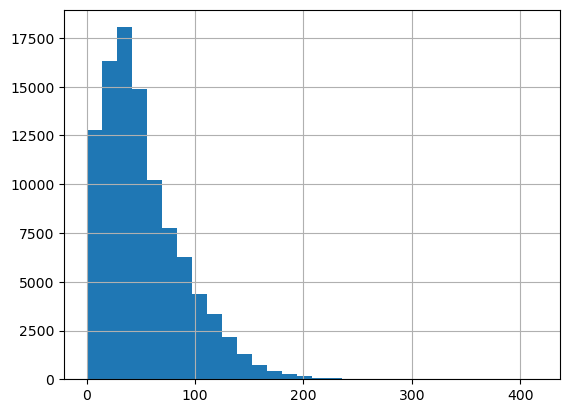

In [189]:
df['ExpectedBagsCount'].hist(bins=30)

In [191]:
df_cleaned = df.drop_duplicates()
df_cleaned.shape

(90794, 10)

In [193]:
audit_df, bad_rows = audit_baggage_data(df_cleaned)

print("=== AUDIT SUMMARY ===")
print(audit_df)

=== AUDIT SUMMARY ===
                                     Issue Count
Check                                           
Invalid Bag Drop Order                         0
Bags Delivered Before Arrival                  0
Negative Expected Bag Count                    0
Rows with Missing Fields                       0
Exact Duplicate Rows                           0
Duplicate Flight Entries                      22
Origin Equals Destination                     21
Bag Drop Times with 0 Expected Bags           68
Zero Delivery Duration w/ Bags               104


/var/folders/f9/h1fzr8_920x1wh3dtpzy4cmh0000gn/T/ipykernel_92441/3966770580.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FirstBagDropTime'] = pd.to_datetime(df['FirstBagDropTime'], errors='coerce')
/var/folders/f9/h1fzr8_920x1wh3dtpzy4cmh0000gn/T/ipykernel_92441/3966770580.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LastBagDropTime'] = pd.to_datetime(df['LastBagDropTime'], errors='coerce')
/var/folders/f9/h1fzr8_920x1wh3dtpzy4cmh0000gn/T/ipykernel_92441/3966770580.py:8: SettingWithCop

In [120]:
bad_rows['Duplicate Flight Entries']

,ActualArrival,FlightNumber,Origin,Destination,ExpectedBagsCount,FirstBagDropTime,LastBagDropTime,DeliveryDurationMins,Arrival_To_First,First_To_last
5389,2021-08-06 11:38:00,338,WYV,FTU,58,2021-08-06 11:53:00,2021-08-06 11:55:00,17.0,15.0,2.0
5390,2021-08-06 11:38:00,338,YXY,FTU,42,2021-08-06 11:52:00,2021-08-06 11:54:00,16.0,14.0,2.0
38696,2021-11-07 22:11:00,42,FTU,AAW,65,2021-11-07 22:24:00,2021-11-07 22:26:00,15.0,13.0,2.0
38697,2021-11-07 22:11:00,42,CBZ,WWT,110,2021-11-07 22:20:00,2021-11-07 22:28:00,17.0,9.0,8.0
43263,2021-11-20 08:48:00,567,XFA,FTU,67,2021-11-20 09:06:00,2021-11-20 09:10:00,22.0,18.0,4.0
43264,2021-11-20 08:48:00,567,EXT,FTU,54,2021-11-20 09:08:00,2021-11-20 09:12:00,24.0,20.0,4.0
52726,2021-12-18 21:27:00,34,WFY,TZB,31,2021-12-18 21:36:00,2021-12-18 21:38:00,11.0,9.0,2.0
52727,2021-12-18 21:27:00,34,WWT,XXB,77,2021-12-18 21:31:00,2021-12-18 21:40:00,13.0,4.0,9.0
69025,2022-02-06 13:52:00,592,XCB,EYT,33,2022-02-06 14:05:00,2022-02-06 14:07:00,15.0,13.0,2.0
69026,2022-02-06 13:52:00,592,BEY,FTU,10,2022-02-06 14:03:00,2022-02-06 14:03:00,11.0,11.0,0.0


In [121]:
bad_rows['Origin Equals Destination']

,ActualArrival,FlightNumber,Origin,Destination,ExpectedBagsCount,FirstBagDropTime,LastBagDropTime,DeliveryDurationMins,Arrival_To_First,First_To_last
12385,2021-08-29 14:12:00,2583,XCB,XCB,23,2021-08-29 14:17:00,2021-08-29 14:18:00,6.0,5.0,1.0
49438,2021-12-09 13:27:00,92,CAX,CAX,91,2021-12-09 13:30:00,2021-12-09 13:37:00,10.0,3.0,7.0
57942,2022-01-05 14:17:00,3095,YZU,YZU,36,2022-01-05 14:25:00,2022-01-05 14:27:00,10.0,8.0,2.0
64887,2022-01-25 22:01:00,447,WWT,WWT,57,2022-01-25 22:13:00,2022-01-25 22:20:00,19.0,12.0,7.0
67231,2022-02-01 21:01:00,96,FTU,FTU,28,2022-02-01 21:12:00,2022-02-01 21:13:00,12.0,11.0,1.0
68204,2022-02-04 21:52:00,7708,XCB,XCB,14,2022-02-04 21:53:00,2022-02-04 21:53:00,1.0,1.0,0.0
70239,2022-02-08 16:28:00,866,FTU,FTU,40,2022-02-08 16:45:00,2022-02-08 16:47:00,19.0,17.0,2.0
72951,2022-02-11 17:23:00,1290,FTU,FTU,41,2022-02-11 17:36:00,2022-02-11 17:38:00,15.0,13.0,2.0
75678,2022-02-14 13:47:00,688,FTU,FTU,74,2022-02-14 14:05:00,2022-02-14 14:10:00,23.0,18.0,5.0
75754,2022-02-14 14:36:00,1290,FTU,FTU,68,2022-02-14 14:50:00,2022-02-14 14:57:00,21.0,14.0,7.0


In [122]:
bad_rows['Bag Drop Times with 0 Expected Bags']

,ActualArrival,FlightNumber,Origin,Destination,ExpectedBagsCount,FirstBagDropTime,LastBagDropTime,DeliveryDurationMins,Arrival_To_First,First_To_last
58,2021-07-22 10:31:00,1985,WWC,FTU,0,2021-07-22 10:40:00,2021-07-22 10:40:00,9.0,9.0,0.0
1063,2021-07-25 06:07:00,5814,VED,FTU,0,2021-07-25 06:27:00,2021-07-25 06:27:00,20.0,20.0,0.0
1112,2021-07-25 12:25:00,8846,DFX,FTU,0,2021-07-25 12:37:00,2021-07-25 12:38:00,13.0,12.0,1.0
1924,2021-07-27 10:31:00,4201,DFX,FTU,0,2021-07-27 10:47:00,2021-07-27 10:47:00,16.0,16.0,0.0
2889,2021-07-30 06:21:00,90,WWA,FTU,0,2021-07-30 06:29:00,2021-07-30 06:29:00,8.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...
94732,2022-03-11 15:03:00,396,WET,FTU,0,2022-03-11 15:16:00,2022-03-11 15:16:00,13.0,13.0,0.0
95244,2022-03-12 06:38:00,3833,VXX,FTU,0,2022-03-12 06:50:00,2022-03-12 06:59:00,21.0,12.0,9.0
95256,2022-03-12 07:16:00,2915,CED,FTU,0,2022-03-12 07:30:00,2022-03-12 07:32:00,16.0,14.0,2.0
96167,2022-03-13 11:44:00,8418,ZEY,FTU,0,2022-03-13 11:55:00,2022-03-13 11:56:00,12.0,11.0,1.0


In [123]:
bad_rows['Zero Delivery Duration w/ Bags']

,ActualArrival,FlightNumber,Origin,Destination,ExpectedBagsCount,FirstBagDropTime,LastBagDropTime,DeliveryDurationMins,Arrival_To_First,First_To_last
1007,2021-07-24 23:21:00,7262,FTU,YXY,108,2021-07-24 23:21:00,2021-07-24 23:21:00,0.0,0.0,0.0
8828,2021-08-17 16:15:00,6345,AAW,CYT,17,2021-08-17 16:15:00,2021-08-17 16:15:00,0.0,0.0,0.0
12851,2021-08-30 18:49:00,1075,AAW,XCB,2,2021-08-30 18:49:00,2021-08-30 18:49:00,0.0,0.0,0.0
19498,2021-09-18 19:03:00,2441,FUC,XCB,4,2021-09-18 19:03:00,2021-09-18 19:03:00,0.0,0.0,0.0
22005,2021-09-24 23:32:00,1190,FUX,XCB,10,2021-09-24 23:32:00,2021-09-24 23:32:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
96816,2022-03-14 08:29:00,3382,YZU,FTU,18,2022-03-14 08:29:00,2022-03-14 08:29:00,0.0,0.0,0.0
96968,2022-03-14 11:20:00,5749,AAW,XCB,22,2022-03-14 11:20:00,2022-03-14 11:20:00,0.0,0.0,0.0
98227,2022-03-15 18:43:00,7708,CED,XCB,41,2022-03-15 18:43:00,2022-03-15 18:43:00,0.0,0.0,0.0
98630,2022-03-16 10:30:00,192,FTU,XCB,41,2022-03-16 10:30:00,2022-03-16 10:30:00,0.0,0.0,0.0


In [171]:
# Find partial duplicates (same flight and arrival, but different full rows)
flight_dups = df_cleaned[df_cleaned.duplicated(subset=['FlightNumber', 'ActualArrival'], keep=False)]
not_exact_dups = flight_dups[~flight_dups.duplicated(keep=False)]

print(f"Partial duplicates (same flight/time, diff content): {len(not_exact_dups)}")
not_exact_dups.head()

Partial duplicates (same flight/time, diff content): 22


,ActualArrival,FlightNumber,Origin,Destination,ExpectedBagsCount,FirstBagDropTime,LastBagDropTime,DeliveryDurationMins,Arrival_To_First,First_To_last
5389,2021-08-06 11:38:00,338,WYV,FTU,58,2021-08-06 11:53:00,2021-08-06 11:55:00,17.0,15.0,2.0
5390,2021-08-06 11:38:00,338,YXY,FTU,42,2021-08-06 11:52:00,2021-08-06 11:54:00,16.0,14.0,2.0
38696,2021-11-07 22:11:00,42,FTU,AAW,65,2021-11-07 22:24:00,2021-11-07 22:26:00,15.0,13.0,2.0
38697,2021-11-07 22:11:00,42,CBZ,WWT,110,2021-11-07 22:20:00,2021-11-07 22:28:00,17.0,9.0,8.0
43263,2021-11-20 08:48:00,567,XFA,FTU,67,2021-11-20 09:06:00,2021-11-20 09:10:00,22.0,18.0,4.0


In [124]:
route_counts = df.groupby(['Origin', 'Destination']).size().reset_index(name='RouteCount')

In [125]:
route_stats = df.groupby(['Origin', 'Destination'])['DeliveryDurationMins'].agg(['count', 'mean', 'std', 'min', 'max', 'median']).reset_index()

In [126]:
route_stats['CV'] = route_stats['std'] / route_stats['mean']

In [127]:
route_stats

,Origin,Destination,count,mean,std,min,max,median,CV
0,AAW,CYT,440,11.015909,3.442627,0.0,25.0,11.0,0.312514
1,AAW,EYT,132,11.522727,5.114664,0.0,33.0,12.0,0.443876
2,AAW,FTU,412,17.871359,6.055337,7.0,39.0,17.0,0.338829
3,AAW,FUX,75,11.480000,2.965386,6.0,18.0,11.0,0.258309
4,AAW,FXX,57,16.947368,4.335983,11.0,31.0,16.0,0.255850
...,...,...,...,...,...,...,...,...,...
635,ZEY,FTU,189,15.730159,4.680902,8.0,35.0,15.0,0.297575
636,ZFB,FTU,82,17.280488,4.092373,10.0,26.0,16.5,0.236820
637,ZFV,FTU,58,21.327586,7.563504,9.0,38.0,22.0,0.354635
638,ZXY,FTU,1,14.000000,NaN,14.0,14.0,14.0,NaN


In [128]:
df_cleaned

,ActualArrival,FlightNumber,Origin,Destination,ExpectedBagsCount,FirstBagDropTime,LastBagDropTime,DeliveryDurationMins,Arrival_To_First,First_To_last
0,2021-07-22 08:20:00,8390,EVF,YZU,6,2021-07-22 08:29:00,2021-07-22 08:29:00,9.0,9.0,0.0
1,2021-07-22 08:20:00,6898,CYT,YZU,24,2021-07-22 08:30:00,2021-07-22 08:31:00,11.0,10.0,1.0
2,2021-07-22 08:20:00,3095,YZU,EVF,27,2021-07-22 08:26:00,2021-07-22 08:29:00,9.0,6.0,3.0
3,2021-07-22 08:31:00,4821,CYT,YUX,17,2021-07-22 08:41:00,2021-07-22 08:45:00,14.0,10.0,4.0
4,2021-07-22 08:33:00,2512,EYT,YZU,32,2021-07-22 08:40:00,2021-07-22 08:42:00,9.0,7.0,2.0
...,...,...,...,...,...,...,...,...,...,...
99169,2022-08-12 06:26:00,711,FXX,FTU,49,2022-08-12 06:50:00,2022-08-12 06:53:00,27.0,24.0,3.0
99170,2022-08-12 07:00:00,254,FTU,WET,31,2022-08-12 07:06:00,2022-08-12 07:08:00,8.0,6.0,2.0
99171,2022-08-12 07:02:00,648,WWT,VYZ,72,2022-08-12 07:12:00,2022-08-12 07:16:00,14.0,10.0,4.0
99172,2022-08-12 07:14:00,5337,WET,WWA,14,2022-08-12 07:23:00,2022-08-12 07:25:00,11.0,9.0,2.0


In [129]:
df_cleaned = df_cleaned[~((df_cleaned['ExpectedBagsCount'] > 0) & (df_cleaned['DeliveryDurationMins'] == 0))]

In [130]:
df_cleaned.shape

(90690, 10)

In [131]:
audit_df, bad_rows = audit_baggage_data(df_cleaned)

print("=== AUDIT SUMMARY ===")
print(audit_df)

=== AUDIT SUMMARY ===
                                     Issue Count
Check                                           
Invalid Bag Drop Order                         0
Bags Delivered Before Arrival                  0
Negative Expected Bag Count                    0
Rows with Missing Fields                       0
Exact Duplicate Rows                           0
Duplicate Flight Entries                      22
Origin Equals Destination                     21
Bag Drop Times with 0 Expected Bags           68
Zero Delivery Duration w/ Bags                 0


/var/folders/f9/h1fzr8_920x1wh3dtpzy4cmh0000gn/T/ipykernel_92441/1724725163.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FirstBagDropTime'] = pd.to_datetime(df['FirstBagDropTime'], errors='coerce')
/var/folders/f9/h1fzr8_920x1wh3dtpzy4cmh0000gn/T/ipykernel_92441/1724725163.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LastBagDropTime'] = pd.to_datetime(df['LastBagDropTime'], errors='coerce')
/var/folders/f9/h1fzr8_920x1wh3dtpzy4cmh0000gn/T/ipykernel_92441/1724725163.py:8: SettingWithCop

In [132]:
# df_cleaned.to_csv('cleaned_baggage_data.csv', index=False)

In [133]:
df.shape[0]

99174

In [134]:
df_cleaned

,ActualArrival,FlightNumber,Origin,Destination,ExpectedBagsCount,FirstBagDropTime,LastBagDropTime,DeliveryDurationMins,Arrival_To_First,First_To_last
0,2021-07-22 08:20:00,8390,EVF,YZU,6,2021-07-22 08:29:00,2021-07-22 08:29:00,9.0,9.0,0.0
1,2021-07-22 08:20:00,6898,CYT,YZU,24,2021-07-22 08:30:00,2021-07-22 08:31:00,11.0,10.0,1.0
2,2021-07-22 08:20:00,3095,YZU,EVF,27,2021-07-22 08:26:00,2021-07-22 08:29:00,9.0,6.0,3.0
3,2021-07-22 08:31:00,4821,CYT,YUX,17,2021-07-22 08:41:00,2021-07-22 08:45:00,14.0,10.0,4.0
4,2021-07-22 08:33:00,2512,EYT,YZU,32,2021-07-22 08:40:00,2021-07-22 08:42:00,9.0,7.0,2.0
...,...,...,...,...,...,...,...,...,...,...
99169,2022-08-12 06:26:00,711,FXX,FTU,49,2022-08-12 06:50:00,2022-08-12 06:53:00,27.0,24.0,3.0
99170,2022-08-12 07:00:00,254,FTU,WET,31,2022-08-12 07:06:00,2022-08-12 07:08:00,8.0,6.0,2.0
99171,2022-08-12 07:02:00,648,WWT,VYZ,72,2022-08-12 07:12:00,2022-08-12 07:16:00,14.0,10.0,4.0
99172,2022-08-12 07:14:00,5337,WET,WWA,14,2022-08-12 07:23:00,2022-08-12 07:25:00,11.0,9.0,2.0
